500 hPa Vorticity Advection
===========================

Plot an 500-hPa map with calculating vorticity advection using MetPy calculations.

Beyond just plotting 500-hPa level data, this uses calculations from `metpy.calc` to find
the vorticity and vorticity advection. Currently, this needs an extra helper function to
calculate the distance between lat/lon grid points.

Imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.ncss import NCSS

Data Aquisition
---------------

In [2]:
# Open the example netCDF data
ncss = NCSS('https://www.ncei.noaa.gov/thredds/ncss/grid/namanl/'
            '201604/20160416/namanl_218_20160416_1800_000.grb')
now = datetime.utcnow()

# Query for Latest GFS Run
hgt = ncss.query().time(datetime(2016, 4, 16, 18)).accept('netcdf')
hgt.variables('Geopotential_height_isobaric', 'u-component_of_wind_isobaric',
              'v-component_of_wind_isobaric').add_lonlat()

# Actually getting the data
ds = ncss.get_data(hgt)

lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]

times = ds.variables[ds.variables['Geopotential_height_isobaric'].dimensions[0]]
vtime = num2date(times[:], units=times.units)


lev_500 = np.where(ds.variables['isobaric'][:] == 500)[0][0]

hght_500 = ds.variables['Geopotential_height_isobaric'][0, lev_500, :, :]
hght_500 = ndimage.gaussian_filter(hght_500, sigma=3, order=0) * units.meter

uwnd_500 = units('m/s') * ds.variables['u-component_of_wind_isobaric'][0, lev_500, :, :]
vwnd_500 = units('m/s') * ds.variables['v-component_of_wind_isobaric'][0, lev_500, :, :]

Begin Data Calculations
-----------------------

In [3]:
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

f = mpcalc.coriolis_parameter(np.deg2rad(lat)).to(units('1/sec'))

avor = mpcalc.vorticity(uwnd_500, vwnd_500, dx, dy, dim_order='yx') + f

avor = ndimage.gaussian_filter(avor, sigma=3, order=0) * units('1/s')

vort_adv = mpcalc.advection(avor, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx') * 1e9

Map Creation
------------

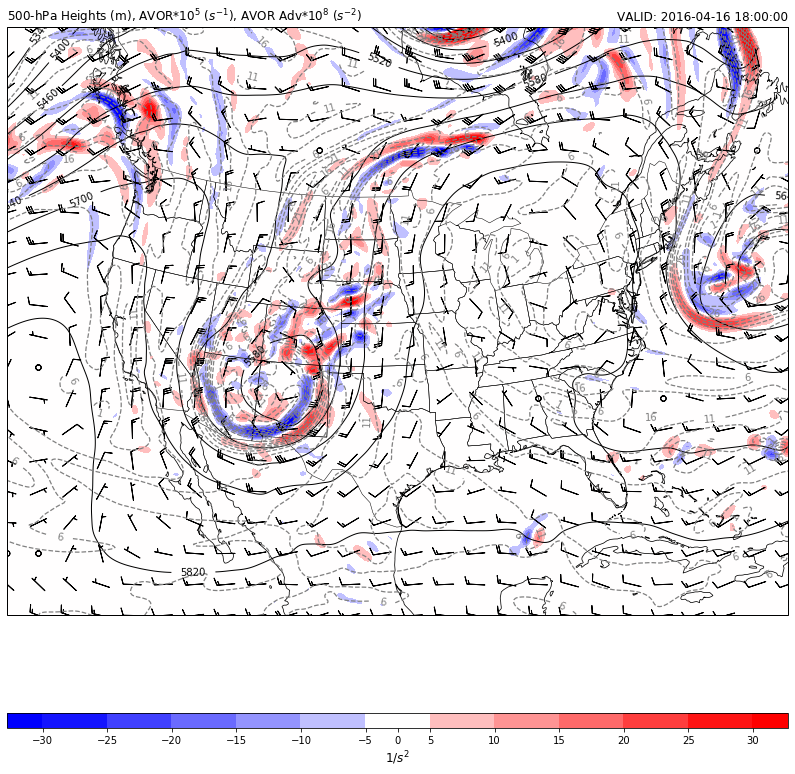

In [4]:
# Set up Coordinate System for Plot and Transforms
dproj = ds.variables['LambertConformal_Projection']
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=dproj.earth_radius,
                   semiminor_axis=dproj.earth_radius)
datacrs = ccrs.LambertConformal(central_latitude=dproj.latitude_of_projection_origin,
                                central_longitude=dproj.longitude_of_central_meridian,
                                standard_parallels=[dproj.standard_parallel],
                                globe=globe)
plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                standard_parallels=[30, 60])

fig = plt.figure(1, figsize=(14., 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title(r'500-hPa Heights (m), AVOR$*10^5$ ($s^{-1}$), AVOR Adv$*10^8$ ($s^{-2}$)',
          loc='left')
plt.title('VALID: {}'.format(vtime[0]), loc='right')

# Plot Background
ax.set_extent([235., 290., 20., 58.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev500 = np.arange(5100, 6061, 60)
cs = ax.contour(lon, lat, hght_500.m, clev500, colors='black', linewidths=1.0,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Absolute Vorticity Contours
clevvort500 = np.arange(-9, 50, 5)
cs2 = ax.contour(lon, lat, avor*10**5, clevvort500, colors='grey',
                 linewidths=1.25, linestyles='dashed', transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Vorticity Advection
clev_avoradv = np.arange(-30, 31, 5)
cf = ax.contourf(lon, lat, vort_adv.m, clev_avoradv[clev_avoradv != 0], extend='both',
                 cmap='bwr', transform=ccrs.PlateCarree())
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='horizontal', extendrect='True', ticks=clev_avoradv)
cb.set_label(r'$1/s^2$', size='large')

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
ax.barbs(lon, lat, uwnd_500.m, vwnd_500.m, length=6, regrid_shape=20,
         pivot='middle', transform=ccrs.PlateCarree())